In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [64]:
import beampipe_parameters
beampipe0=beampipe_parameters.Beampipe()

In [3]:
def layer_boundaries(layer=0, side="L", beampipe=beampipe0):
    
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    if side=="R":
        
        
        phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
        x,y = [-39.8, -39.8, -0.2, -0.2] + list(holeX-holeR*np.cos(phi)) + [-0.2,-0.2, -39.8], \
                 [-29.9,29.9, 29.9, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-29.9, -29.9]
        return Polygon(zip(x,y))
    if side=="L":
        
        phi0 = np.arccos((holeX-.2)/holeR)
        #print((np.pi-phi0)/np.pi*2)
        phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
        x=[19.8, 19.8, 0.2] + list(holeX-np.cos(phi)*holeR) + [0.2, 19.8]
        y=[-29.9,29.9, 29.9]+list(holeR*np.sin(phi)) + [-29.9, -29.9]
        return Polygon(zip(x,y))

In [25]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.86, debug=False, wall_thickness=0.08, wall_scint_gap=0.01, minCellAreaFraction=1/3):
    if wall_thickness!=0:
        poly=poly.buffer(-wall_thickness/2)
    
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+1)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+2
    x0=min(poly.exterior.xy[0])
    
    
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented scint_boundsx scint_boundsy scint_area".split()}
    
    
    shiftX=[-sidelength, 0, sidelength][layer%3]
    shiftY=[0, 0, 0][layer%3]
    
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            #check if the dimple fits inside the boundaries.
            if not Point(x,y).buffer(R_readout).within(poly):
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                
                # now see if shifting the dimple to the centroid will allow the dimple to fit
                # otherwise merge with neighbors
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    continue
                # now see if the cell's area is more than a specified fraction of a 
                # standard hexagon's area.  otherwise merge with neighbors
                if overlap.area/hexagon.area <  minCellAreaFraction:
                    continue
                xc,yc = centroid.xy
                
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
                #smaller hexagon for the scintillator cell.
                scint_sidelength=sidelength-(wall_thickness/2+wall_scint_gap)/(np.sqrt(3)/2)
                hexagon2=Polygon(zip(x+scint_sidelength*np.cos(phi),y+scint_sidelength*np.sin(phi)))
                d['scint_boundsx'].append(hexagon2.exterior.xy[0])
                d['scint_boundsy'].append(hexagon2.exterior.xy[1])
                d['scint_area'].append(hexagon2.area)
            else :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                d['scint_boundsx'].append(scint.exterior.xy[0])
                d['scint_boundsy'].append(scint.exterior.xy[1])
                d['scint_area'].append(scint.area)
            
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    #now extend any cells that need extending.  Need to find a better way to do this
    for i in range(len(df)):
        #check if the neighboring cell is a fragment (which is not in the dataframe)
        #.  If so, take a piece of it and add it to the current cell.  
        dc, dr = (1, 1,0, -1, -1,0), (-1, 1,2,1, -1, -2)
        
        for j in range(len(dc)):
            r=df.row[i]+dr[j]
            c=df.col[i]+dc[j]
            if not len(df.query(f'row== {r} and col=={c}')):
                cell=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                #find center of the fragmented 
                x=x0+(df.col[i]+dc[j])*sidelength*3/2+shiftX
                y=y0+sidelength*np.sqrt(3)/2*(df.row[i]+dr[j])+shiftY
                
                corner1 = (x+df.xh[i])/2+(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2-(df.xh[i]-x)/np.sqrt(3)/2
                corner2 = (x+df.xh[i])/2-(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2+(df.xh[i]-x)/np.sqrt(3)/2
                
                
                merge=Polygon([(x,y), corner1, (df.xh[i], df.yh[i]),corner2])
                
                newpoly=unary_union([cell,merge])
                newpoly=poly.intersection(newpoly).simplify(.0001)
                #print(newpoly)
                if not type(newpoly)== Polygon:
                    if debug: print("warning disjointed polygon!", type(newpoly), j)
                    continue
                df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                df.loc[i,"area"]=newpoly.area
                
                scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                df.loc[i,'scint_area']=scint.area
                
                #if two consecutive neighbors are fragments, merge a larger fraction of both of them into this one
                for dj in 1,:
                    r2=df.row[i]+dr[(j+dj)%6]
                    c2=df.col[i]+dc[(j+dj)%6]
                    if not len(df.query(f'row== {r2} and col=={c2}')):
                        x2=x0+c2*sidelength*3/2+shiftX
                        y2=y0+sidelength*np.sqrt(3)/2*r2+shiftY
                        
                        corner3 = 2*(x+x2)/3-df.xh[i]/3,2*(y+y2)/3-df.yh[i]/3
                        
                        
                        
                        merge=Polygon([(x,y), corner3, (x2,y2), (df.xh[i], df.yh[i])])
                        #print(merge.area)
                        newpoly=unary_union([newpoly,merge])
                        newpoly=poly.intersection(newpoly)
                        #print(newpoly)
                        if not type(newpoly)== Polygon:
                            if debug: print("warning disjointed polygon!","XXXX")
                            continue
                        df.loc[i,"boundsx"][:], df.loc[i,"boundsy"][:]= newpoly.exterior.xy
                        df.loc[i,"area"]=newpoly.area
                        
                        scint=newpoly.buffer(-wall_thickness/2-wall_scint_gap/2)
                        df.loc[i,'scint_boundsx'][:],df.loc[i,'scint_boundsy'][:]=scint.exterior.xy
                        df.loc[i,'scint_area']=scint.area
                        
                tol=1e-7
                if abs(newpoly.area-cell.area)/cell.area>tol:
                    df.loc[i,"augmented"]=1
                
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
    return df
            

In [26]:

def draw_layer(layer, R_readout=0.4, sidelength=1.86, fillDimple=True):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    color='krb'[layer%3]
    for side in "LR":
        boundaries=layer_boundaries(layer, side)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength)
        for i in range(len(df)):
            plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                      linestyle='' if fillDimple else '-',
                                                    fill=fillDimple))
            
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

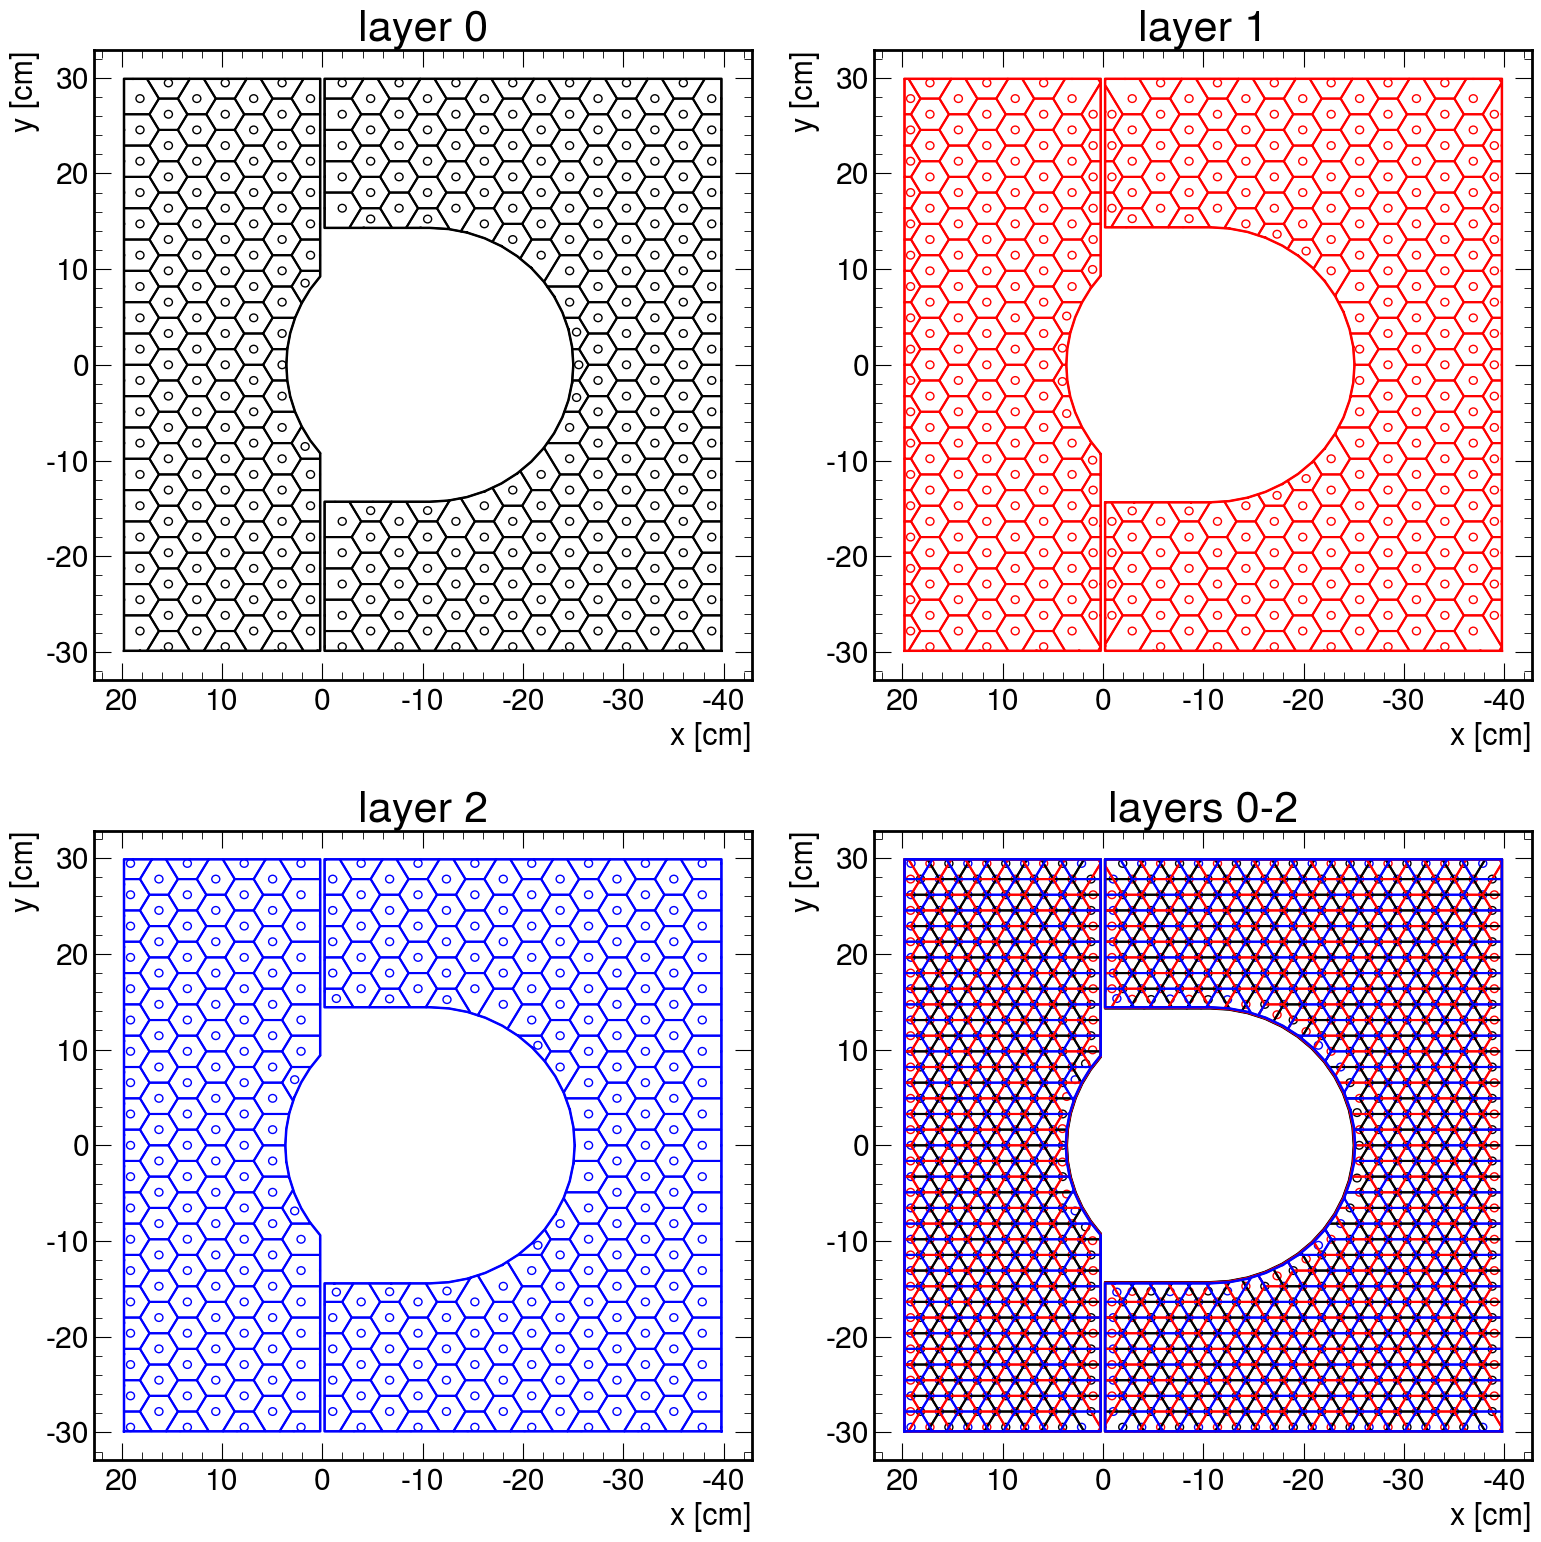

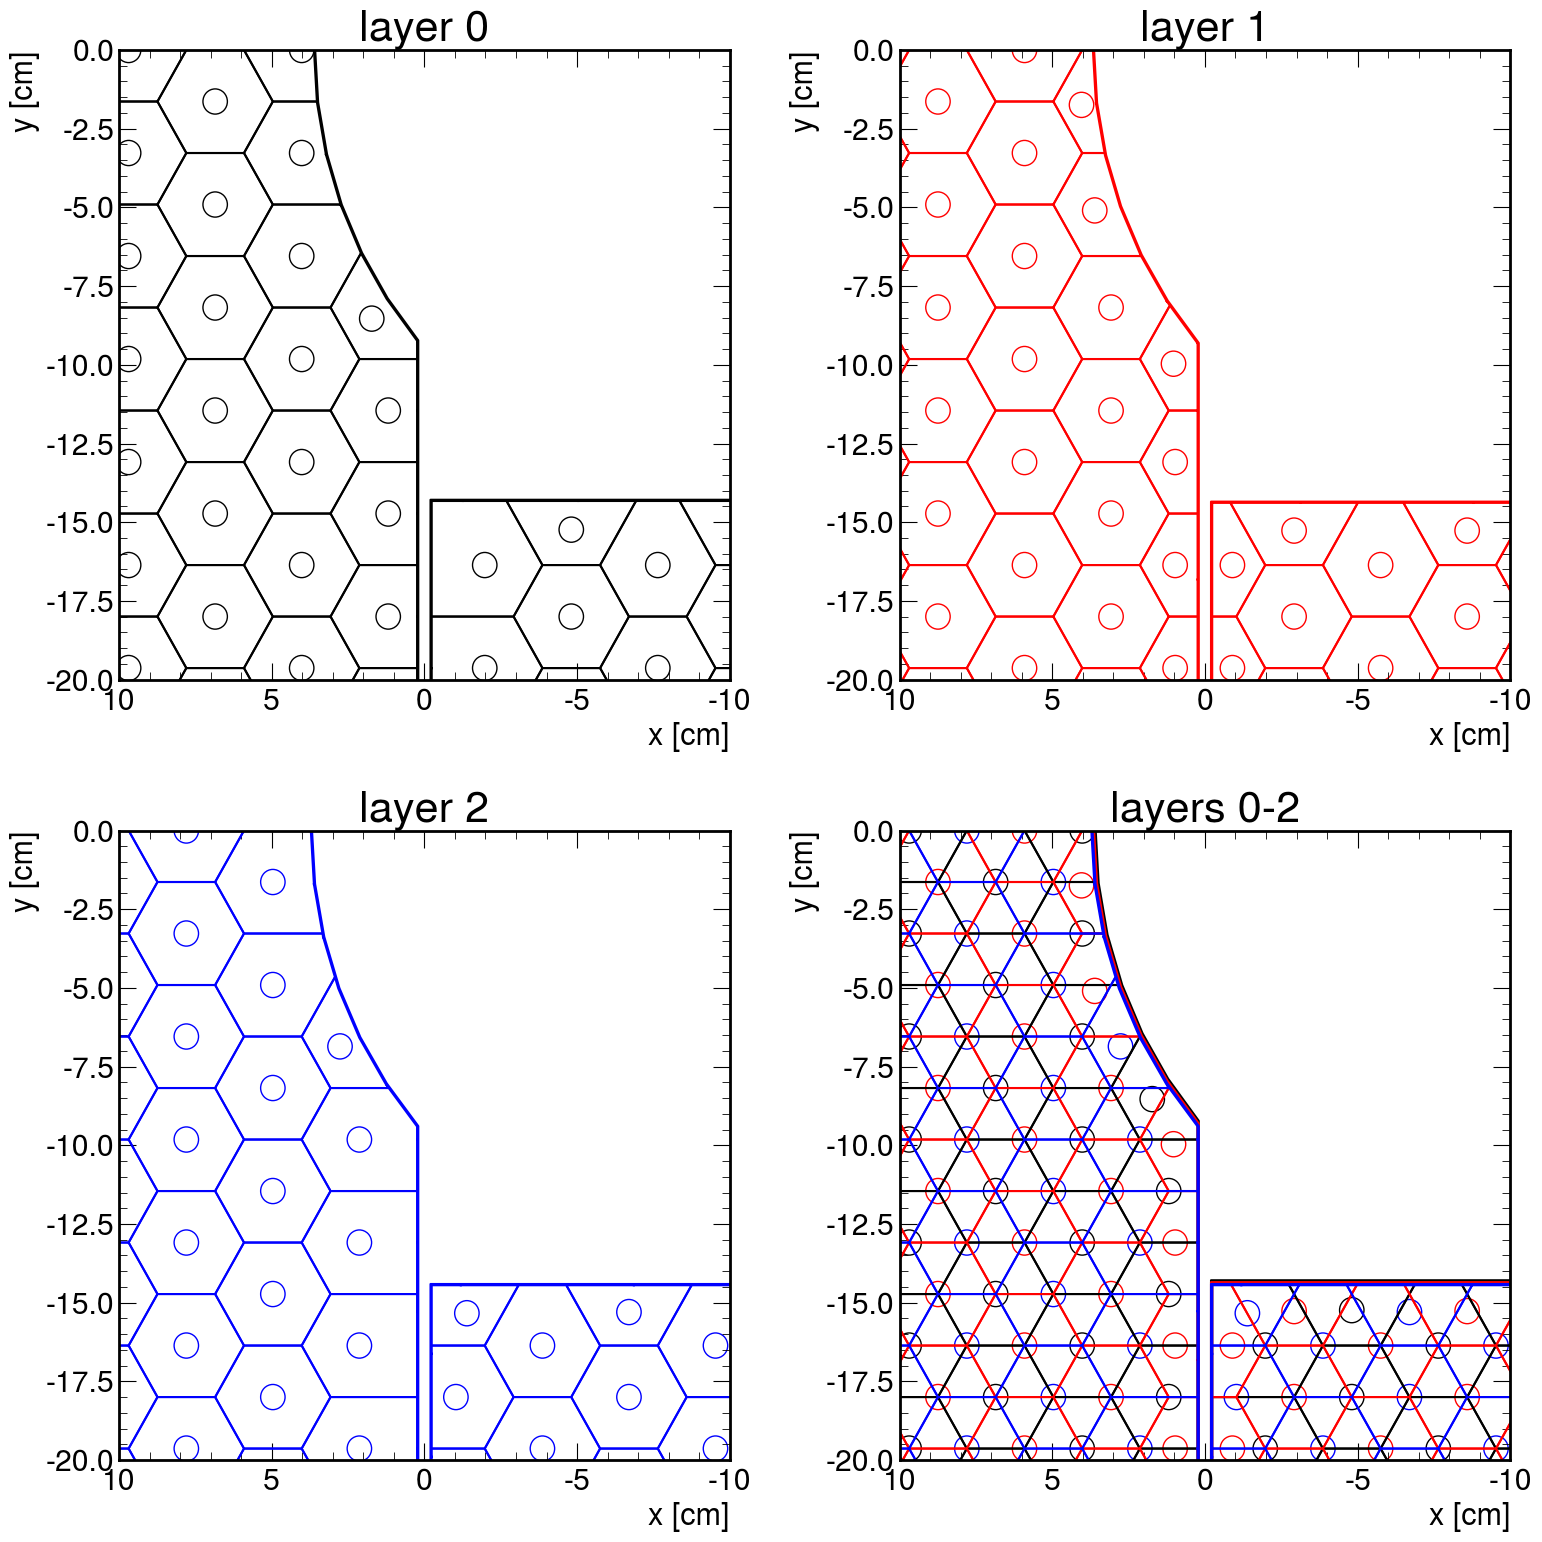

In [27]:
#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)

for zoom in False, True:
    arg=dict(fillDimple=False, sidelength=sidelength)
    fig,axs=plt.subplots(2,2, figsize=(16,16))
    for i in range(3):

        plt.sca(axs[i//2][i%2])
        plt.title(f"layer {i}")
        draw_layer(i, **arg)
        plt.gca().invert_xaxis()
        plt.sca(axs[1][1])
        plt.title(f"layers 0-2")
        draw_layer(i, **arg)
    axs[1][1].invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"Layers_0-2{'_zoom' if zoom else ''}.pdf")
    plt.show()

In [28]:
def print_summary_stats(df, boundary):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=boundary.area
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"area covered by regular hexagons: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"# of regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")
    
    scint_area=sum(df.scint_area)
    scint_hex_area=sum(df.query("augmented==0 and cropped==0").scint_area)
    
    print(f"scintillator area: {scint_area} cm^2")
    print(f"dead area: {tot_area-scint_area:.1f} cm^2  ({100*(tot_area-scint_area)/scint_area:.1f}%)")
    
    
    print(f"area covered by regular hexagon scintillators: {scint_hex_area:.1f} cm^2 ({100*scint_hex_area/tot_area:.1f}% of total)")
    
    

In [29]:
def write_for_openscad(df, file=None, wall_thickness=0.8, frame_height=3):
    segments=[]
    print("segments=[", file=file)
    lines=[]
    #keep track of 90 degree corners, so that they can be made 90 degree square corners instead of rounded
    corners=[]
    for i in range(len(df)):
        for j in range(len(df.boundsx[i])-1):
            segment = {(df.boundsx[i][j], df.boundsy[i][j]), (df.boundsx[i][j+1], df.boundsy[i][j+1])}
            tol=1e-6
            if j!=0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][j-1])<tol \
                      or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][j-1])<tol) or \
                j==0 and (abs(df.boundsx[i][j]-df.boundsx[i][j+1])<tol and abs(df.boundsy[i][j]-df.boundsy[i][-2])<tol \
                       or abs(df.boundsy[i][j]-df.boundsy[i][j+1])<tol and abs(df.boundsx[i][j]-df.boundsx[i][-2])<tol):
                corner = (df.boundsx[i][j], df.boundsy[i][j])
                #print(corner)
                if corner not in corners:
                    corners.append(corner)
            if segment not in segments:
                lines.append(f"[[{10*df.boundsx[i][j]:.3f},{10*df.boundsy[i][j]:.3f}], [{10*df.boundsx[i][j+1]:.3f}, {10*df.boundsy[i][j+1]:.3f}]]")
                segments.append(segment)
        #print()
    print(",\n".join(lines), file=file)
    print("];", file=file)
    
    #add points for square corners if applicable.  
    if corners:
        print("corners=[", file=file)
        lines=[]
        for corner in corners:
            lines.append(f"  [{10*corner[0]:.3f}, {10*corner[1]:.3f}]")
        print(",\n".join(lines)+"\n];", file=file)
    else:
        print("corners=[];", file=file)
    print(f"wall_thickness={wall_thickness};\nframe_height={frame_height};", file=file)
    print(f"include <make_3d_frame.scad>", file=file)

In [30]:
#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)
print(sidelength)

1.88918802153517


In [56]:
#now test this for the first and last layers:
wall_thickness=0.8
frame_height=3

for layer, sidelength in zip((0, 59),(1.889, 3.722)):
    
    scadfile=f"openscad/layer_{layer}.scad"
    with open(scadfile, "w") as f:
        
        for side in "LR":
            #begin new scope for each side
            print(f"module side{side}() {{", file=f)
            #print("{", file=f)

            bounds=layer_boundaries(layer, side, beampipe0)
            df=cell_positions(layer, bounds,
                               R_readout=0.4, sidelength=sidelength)
            print(f"side: {side} layer: {layer}")
            print_summary_stats(df, bounds)
            write_for_openscad(df, file=f, wall_thickness=wall_thickness, frame_height=frame_height)
            print("}", file=f)
            print(f"side{side}();", file=f)
            print()
            
        #now add information to put on the plaque
        holeR, holeX=beampipe0.holeR(layer), beampipe0.holeX(layer)
        print("include <make_plaque.scad>", file=f)
        print("lines=[", file=f)
        def add_line(line):
            print(f'"{line}",', file=f)
        add_line(f"layer {layer}")
        add_line(f"hole radius={holeR:.2f} cm")
        add_line(f"hole position={holeX:.2f} cm")
        add_line(f"side length={sidelength:.2f} cm")
        add_line(f"wall height={frame_height:.1f} mm")
        add_line(f"wall thickness={wall_thickness:.1f} mm")
        print("];", file=f)
        print("plaque(lines);", file=f)
    import os
    try:
        os.mkdir("stl")
    except:
        pass
    try:
        os.mkdir("png")
    except:
        pass
    #assuming you have openscad installed 
    stlfile=f"stl/layer_{layer}.stl"
    pngfile=f"png/layer_{layer}.png"
    
    camera="-200,900,1500,-100,0,0"
    os.system(f'OpenSCAD --camera {camera} --imgsize=1600,1600 -o {pngfile} -o {stlfile} -D pcb_all_layers=true {scadfile}') 

side: L layer: 0
total area: 1129.8 cm^2
area covered by regular hexagons: 723.1 cm^2
(regular hexagon area)/(total area): 64.0%
total cells: 125
# of regular hexagon cells: 78
(regular hexagon cells)/(total cells): 62.4%
scintillator area: 1056.0717705857762 cm^2
dead area: 73.7 cm^2  (7.0%)
area covered by regular hexagon scintillators: 679.6 cm^2 (60.2% of total)

side: R layer: 0
total area: 1748.1 cm^2
area covered by regular hexagons: 1131.0 cm^2
(regular hexagon area)/(total area): 64.7%
total cells: 195
# of regular hexagon cells: 122
(regular hexagon cells)/(total cells): 62.6%
scintillator area: 1633.7530480129813 cm^2
dead area: 114.3 cm^2  (7.0%)
area covered by regular hexagon scintillators: 1063.0 cm^2 (60.8% of total)



Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"
Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 4596
Geometry cache size in bytes: 2755552
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.401
Geometries in cache: 4598
Geometry cache size in bytes: 3553616
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 21564544
Total rendering time: 0:00:14.430
Top level object is a 3D object:
   Simple:        yes
   Vertices:    10264
   Halfedges:   30792
   Edges:       15396
   Halffacets:  10554
   Facets:       5277
   Volumes:         4


side: L layer: 59
total area: 1050.5 cm^2
area covered by regular hexagons: 144.0 cm^2
(regular hexagon area)/(total area): 13.7%
total cells: 27
# of regular hexagon cells: 4
(regular hexagon cells)/(total cells): 14.8%
scintillator area: 1014.2224461198115 cm^2
dead area: 36.2 cm^2  (3.6%)
area covered by regular hexagon scintillators: 139.5 cm^2 (13.3% of total)

side: R layer: 59
total area: 1480.9 cm^2
area covered by regular hexagons: 144.0 cm^2
(regular hexagon area)/(total area): 9.7%
total cells: 41
# of regular hexagon cells: 4
(regular hexagon cells)/(total cells): 9.8%
scintillator area: 1427.79335286632 cm^2
dead area: 53.2 cm^2  (3.7%)
area covered by regular hexagon scintillators: 139.5 cm^2 (9.4% of total)



Fontconfig warning: "/Applications/OpenSCAD.app/Contents/Resources/fonts/fonts.conf", line 84: unknown element "blank"
Compiling design (CSG Products normalization)...
Normalized CSG tree has 4 elements
Geometries in cache: 1405
Geometry cache size in bytes: 1523616
CGAL Polyhedrons in cache: 0
CGAL cache size in bytes: 0
Total rendering time: 0:00:00.250
Geometries in cache: 1407
Geometry cache size in bytes: 2325136
CGAL Polyhedrons in cache: 2
CGAL cache size in bytes: 17671296
Total rendering time: 0:00:11.239
Top level object is a 3D object:
   Simple:        yes
   Vertices:     7360
   Halfedges:   22080
   Edges:       11040
   Halffacets:   7646
   Facets:       3823
   Volumes:         4


In [55]:
#now tabulate all layers.  
all_layers ={}
sidelengths=[1.843]*9+[3.102]*9 + [3.722]*42
for layer in range(60):
    for side in "LR":
        bounds=layer_boundaries(layer, side)
        all_layers[(layer, side)]=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelengths[layer])

/opt/homebrew/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)


KeyboardInterrupt: 

In [11]:
for layer, side in all_layers:
    with open(f"openscad/boundaries_{layer}_{side}.scad", "w") as f:
        write_for_openscad(all_layers[(layer,side)], file=f)

In [ ]:
# make an eta vs acceptance plot like those in the HCal Insert paper

In [76]:
def draw_mask(layer, beampipe=beampipe0):
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    beampipeX=beampipe.beampipeX(layer)
    beampipeR=beampipe.beampipeR(layer)
    z=beampipe.getZ(layer)
    #D hole
    plt.gca().add_patch(plt.Circle((holeX, 0), holeR, color='#ffffff', zorder=99))    
    plt.gca().add_patch(plt.Rectangle((holeX, -holeR), -holeX, holeR*2, color='#ffffff', zorder=99))
    #top
    plt.gca().add_patch(plt.Rectangle((24.8-69.6,29.9), 69.6,4.8, color='#ffffff', zorder=99))
    #bottom
    plt.gca().add_patch(plt.Rectangle((24.8-69.6,-34.8), 69.6,-29.9+34.8, color='#ffffff', zorder=99))
    #right
    plt.gca().add_patch(plt.Rectangle((19.8,-34.8), -19.8+24.8,69.6, color='#ffffff', zorder=99))
    #left
    plt.gca().add_patch(plt.Rectangle((-39.8-5.0,-34.8), 5.0,69.6, color='#ffffff', zorder=99))
    
    #gap
    plt.gca().add_patch(plt.Rectangle((-0.2,-29.9), 0.4, 59.8, color='#ffffff', zorder=99))
    
    #draw beampipe
    phi= np.linspace(0, 2*np.pi, 101)
    plt.plot(beampipeX+beampipeR*np.cos(phi), beampipeR*np.sin(phi), color='k', linewidth=0.5, zorder=100)
    plt.plot(beampipeX+(beampipeR-.4)*np.cos(phi), (beampipeR-.4)*np.sin(phi), color='k', linewidth=0.5, zorder=100)



    #draw outline of sensor
    plt.plot([holeX,-.2,-.2,-39.8,-39.8, -.2, -.2, holeX], [-holeR,-holeR,-29.9, -29.9, 29.9, 29.9,holeR, holeR], 
             color='k', linewidth=0.5,zorder=100)
    phi = np.linspace(-np.pi/2, np.pi/2, 25)
    plt.plot(holeX-np.cos(phi)*holeR, holeR*np.sin(phi), color='k', linewidth=0.5, zorder=100)


    phi0 = np.arccos((holeX-.2)/holeR)
    plt.plot([.2,.2,19.8,19.8, .2, .2], [-holeR*np.sin(phi0),-29.9, -29.9, 29.9, 29.9, 
                                               holeR*np.sin(phi0)], color='k', linewidth=0.5, zorder=100)
    phi = np.linspace(phi0,2*np.pi-phi0, 25)
    plt.plot(holeX-np.cos(phi)*holeR, holeR*np.sin(phi), color='k', linewidth=0.5,zorder=100)
    
    #next label the z axis, beampipe center, and z* axis
    plt.plot([0],[0], marker="s", zorder=100, color='b')
    plt.text(0,0, " $z$", color='b', fontsize=17, horizontalalignment='left', zorder=100)
    
    plt.plot([-z*.025],[0], marker='*', zorder=100, color='r')
    plt.text(-z*.025,0, " $z^*$", color='r', fontsize=17, 
             horizontalalignment='left', zorder=100)
    
    #draw arrows indicating clearance and beampipe radii, including arrowheads
    arrowhead=0.8
    args=dict(marker="",linestyle='-', zorder=100, color='k', linewidth=0.7)
    plt.plot([holeX, holeX],[0, beampipeR], **args)
    plt.plot([holeX+arrowhead, holeX, holeX-arrowhead], [beampipeR-arrowhead, beampipeR, beampipeR-arrowhead], **args)
    plt.plot([holeX+arrowhead, holeX, holeX-arrowhead], [arrowhead, 0, arrowhead], **args)
    plt.plot([holeX],[0], marker='o', zorder=100, color='k')
    plt.plot([holeX, holeX],[-beampipeR, -holeR], **args)
    plt.plot([holeX+arrowhead, holeX, holeX-arrowhead], [-beampipeR-arrowhead, -beampipeR, -beampipeR-arrowhead], **args)
    plt.plot([holeX+arrowhead, holeX, holeX-arrowhead], [-holeR+arrowhead, -holeR, -holeR+arrowhead], **args)
    plt.text(holeX, beampipeR/2, f" {beampipeR:.2f} cm", zorder=100, verticalalignment='center', fontsize=15)
    plt.text(holeX, -(holeR+beampipeR)/2, f" {holeR-beampipeR:.2f} cm", zorder=100, verticalalignment='center', fontsize=15)
    

In [77]:
beamTheta=-0.025
def eta_plot(layer, beampipe=beampipe0):
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    z=beampipe.getZ(layer)
    
    for i,eta in enumerate(reversed(np.linspace(3.2, 4.0,9))):
              
        ls = ["--", ":", "-.", "-", (0, (3, 3, 1, 3, 1, 3)), (0, (3, 1, 1, 1, 1, 1)), (0, (3, 3, 1, 3)), (0, (5, 5)), (0,(3,1.4))][i]
        
        #for the legend
        a=plt.plot([],[], label= f"$\eta^*$={eta:.1f}", linestyle=ls, linewidth=3 if eta==3.7 else 2)
        color= a[0].get_color()
        
        if layer == -1:
            continue
        
        tanTheta=np.tan(2*np.arctan(np.exp(-eta)))
        phi= np.linspace(0, 2*np.pi, 100)
        uxp = tanTheta*np.cos(phi)
        uyp = tanTheta*np.sin(phi)
        uzp = 1
        
        ux = uxp*np.cos(beamTheta)+uzp*np.sin(beamTheta)
        uy = uyp
        uz = -uxp*np.sin(beamTheta)+uzp*np.cos(beamTheta)
        
        ux/=uz
        uy/=uz
        uz/=uz
        
        
        x,y = ux*z, uy*z
        plt.plot(x, y, color=color, linestyle=ls, marker='', linewidth=3 if eta==3.7 else 2)
              
        
        


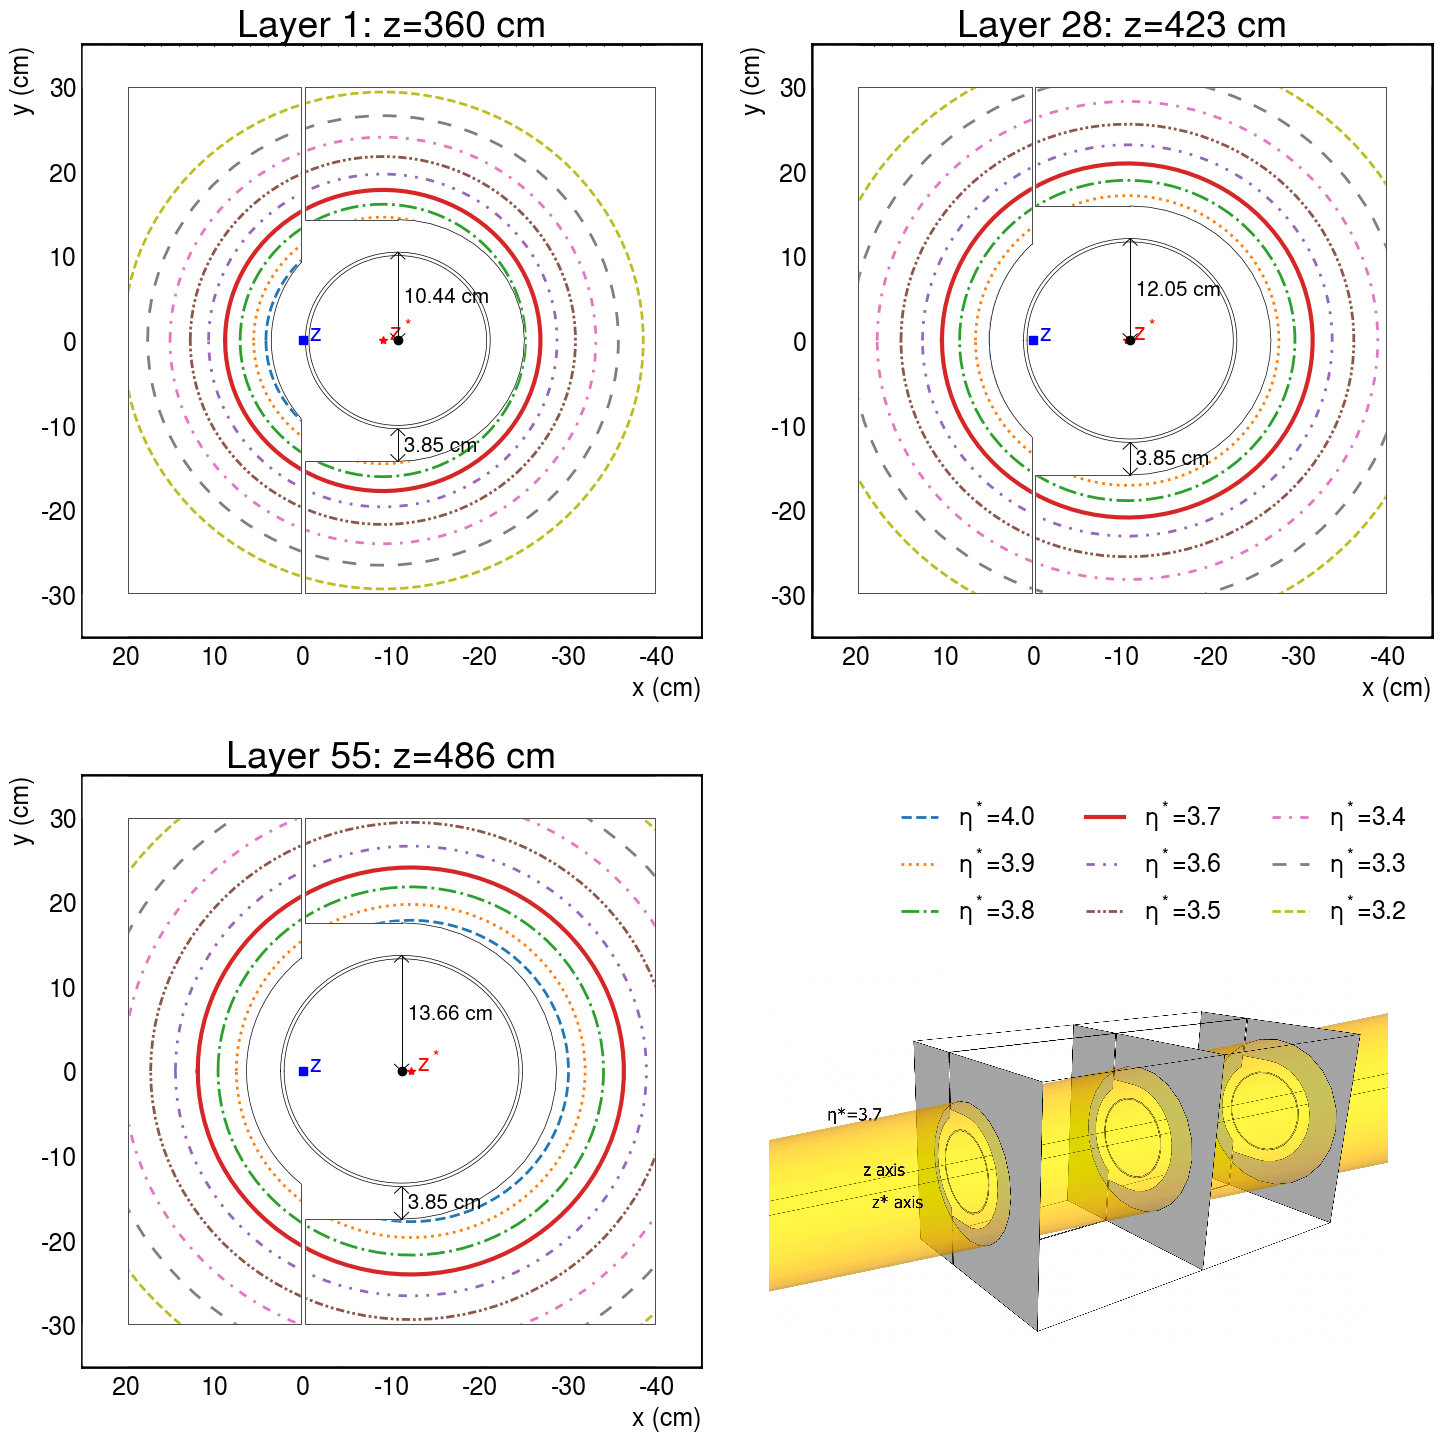

In [129]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

fig, axs= plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
axs[0][0].set_ylim(-35, 35)
axs[0][0].set_xlim(-45, 25)

beampipe=beampipe0

for i, layer in enumerate((0, 27, 54, -1)):
    plt.sca(axs[i//2][i%2])
    eta_plot(layer)
    if layer != -1:
        plt.title(f"Layer {layer+1}: z={beampipe.getZ(layer):.0f} cm", fontsize=27)
        #draw_hexagons(layer, hexArea[layer], alpha=0.2)
        draw_mask(layer)
        plt.xlabel("x (cm)", fontsize=18)
        plt.ylabel("y (cm)", fontsize=18)
        plt.gca().invert_xaxis()
        #plt.text(40, 30, f"clearance={clearance} cm", zorder=100)
axs[1][1].legend(ncol=3, loc="upper right", framealpha=0, fontsize=18)
plt.sca(axs[i//2][i%2])
arr = mpimg.imread('acceptance.png')
zoom=0.17
xy=(-5, -10)
#axs[1][1].set_ylim(0,1)
#axs[1][1].set_xlim(0,1)
imagebox = OffsetImage(arr, zoom=zoom,)
ab = AnnotationBbox(imagebox, xy, frameon=False)
axs[1][1].add_artist(ab)
axs[0][1].tick_params(labelbottom=True, labelsize=18)
axs[0][1].tick_params(labelleft=True, labelsize=18)
axs[0][0].tick_params(labelbottom=True, labelsize=18)
axs[1][0].tick_params(labelsize=18)
axs[1][1].axis('off')
#outdir="plots"
#plt.savefig(f"{outdir}/acceptance_{clearance}cm_clearance.pdf")
#plt.savefig(f"{outdir}/acceptance_{clearance}cm_clearance.png")
plt.tight_layout()
plt.show()

In [9]:
# If we want the height of the detector to be a multiple of one row height, or s*sqrt(3)/2
# then s should be h_det/(N*sqrt(3)/2) for an integer N.  
# Not sure this is necessary though

#determine a table of possible sizes based on this:
htot=59.8
d={key:[] for key in "nrows s A sqrtA ".split()}
for nrows in range(30, 50):
    s=htot/(np.sqrt(3)/2)/nrows
    A=s*s*3*np.sqrt(3)/2
    d['nrows'].append(nrows)
    d['s'].append(s)
    d['A'].append(A)
    d['sqrtA'].append(np.sqrt(A))
df=pd.DataFrame(d)
print(df)

    nrows         s          A     sqrtA
0      30  2.301703  13.764184  3.710011
1      31  2.227455  12.890495  3.590334
2      32  2.157847  12.097428  3.478136
3      33  2.092457  11.375359  3.372738
4      34  2.030914  10.716061  3.273539
5      35  1.972888  10.112462  3.180010
6      36  1.918086   9.558461  3.091676
7      37  1.866246   9.048770  3.008117
8      38  1.817134   8.578785  2.928956
9      39  1.770541   8.144488  2.853855
10     40  1.726277   7.742354  2.782509
11     41  1.684173   7.369284  2.714642
12     42  1.644074   7.022543  2.650008
13     43  1.605839   6.699711  2.588380
14     44  1.569343   6.398639  2.529553
15     45  1.534469   6.117415  2.473341
16     46  1.501111   5.854332  2.419573
17     47  1.469172   5.607861  2.368092
18     48  1.438564   5.376635  2.318757
19     49  1.409206   5.159419  2.271436


In [569]:
np.sqrt(25/(3*np.sqrt(3)/2))
np.sqrt(36/(3*np.sqrt(3)/2))

3.7224194364083982

In [156]:
x,r=beampipe0.holeX(0), beampipe0.holeR(0)
print(x/2.54, r/2.54)

-4.2165152891406334 5.624517479212047


In [159]:
.16*2.54

0.40640000000000004

In [160]:
(15.86+0.08)-11.72

4.219999999999999

In [161]:
24*2.54

60.96

In [109]:
help(OffsetImage)

Help on class OffsetImage in module matplotlib.offsetbox:

class OffsetImage(OffsetBox)
 |  OffsetImage(arr, zoom=1, cmap=None, norm=None, interpolation=None, origin=None, filternorm=True, filterrad=4.0, resample=False, dpi_cor=True, **kwargs)
 |  
 |  Method resolution order:
 |      OffsetImage
 |      OffsetBox
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, arr, zoom=1, cmap=None, norm=None, interpolation=None, origin=None, filternorm=True, filterrad=4.0, resample=False, dpi_cor=True, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  draw(self, renderer)
 |      Update the location of children if necessary and draw them
 |      to the given *renderer*.
 |  
 |  get_children(self)
 |      Return a list of the child `.Artist`\s.
 |  
 |  get_data(self)
 |  
 |  get_extent(self, renderer)
 |      Return a tuple ``width, height, xdescent, ydescent`` of the box.
 |  
 |  get_offset(se